# CryptoMarketAnalysis
# Trabalho de curso de verão
* Autor: 
Marcelo Bianchi Barata Ribeiro
* Professores: 
Renato Rocha e Flavio Coelho
* Exchange escolhida: 
Kucoin
* Local da exchange: 
Hong Kong
* Principais mercados da exchange: 
Apenas criptomoedas. A Kucoin não trabalha com moedas propriamente ditas, tais como dólar ou euro.
* Mercados trabalhados:
Ether (ETH), Litecoin (LTC) e NEO


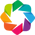

In [1]:
#import os.path
import sys
import copy
import time
import datetime
import sqlite3

import ccxt

#import matplotlib
import holoviews as hv
import pandas as pd
import numpy as np
import warnings
from holoviews.operation.timeseries import rolling, rolling_outlier_std
from holoviews.streams import Stream
hv.notebook_extension('bokeh')
#
from IPython.display import clear_output

In [2]:
import local_tools
import importlib
importlib.reload(local_tools)

<module 'local_tools' from 'D:\\Dropbox\\A-Marcelo\\Educação-Trabalho\\2017-EMAP\\2018-mestrado\\EMAP_repositorios\\verao2018\\local_tools.py'>

# Carregamento do SQLite
Caso a base de dados já esteja construída na pasta, o algoritmo vai carregar a base e transformá-la em dataframe para posterior visualização de dados. Caso contrário, será iniciado processo de coleta de dados por meio do API, onde você pode modificar os parâmetros de coleta. Caso prefira, pode modificar o padrão de parâmetros de captura e armazenamento em arquivo: local_tools, classe: DataRetriever, função: main_builder

### Verifica Banco de dados

In [14]:
#sql_db = 'marcelobbribeiro_ohls_cryptos.sqlite'
sql_db = 'nothing.sqlite'
conn = sqlite3.connect(sql_db)
cur = conn.cursor()
cur.execute('SELECT name FROM sqlite_master WHERE type="table";')
sql_tables = cur.fetchall() 
print('The database has the following tables: ', sql_tables)

The database has the following tables:  []


In [15]:
for table in sql_tables:
    table = table[0].lower()
    if 'eth' in table:
        sql_eth = table
    if 'ltc' in table:
        sql_ltc = table
    if 'neo' in table:
        sql_neo = table
if sql_tables == []:
    sql_eth = 'ETH'
    sql_ltc = 'LTC'
    sql_neo = 'NEO'

### Carrega dados do SQLite

In [16]:
import local_tools
import importlib
importlib.reload(local_tools)

<module 'local_tools' from 'D:\\Dropbox\\A-Marcelo\\Educação-Trabalho\\2017-EMAP\\2018-mestrado\\EMAP_repositorios\\verao2018\\local_tools.py'>

In [ ]:
local_tools.DataLoader(sql_db, sql_eth).check_db()

In [50]:
ohlcv_eth_df = local_tools.DataLoader(sql_db, sql_eth, show_connection = True).load_sql_table()
ohlcv_ltc_df = local_tools.DataLoader(sql_db, sql_ltc).load_sql_table()
ohlcv_neo_df = local_tools.DataLoader(sql_db, sql_neo).load_sql_table()

Connected to marcelobbribeiro_ohls_cryptos.sqlite, table ETH


In [51]:
''' Cria dicionário de dataframes que será utilizado ao longo do resto do trabalho'''
dataframes_dict = {'ETH': ohlcv_eth_df, 'LTC': ohlcv_ltc_df, 'NEO': ohlcv_neo_df}

### Verifica dados de cada tabela do DB

In [56]:
for data_key,data_val in dataframes_dict.items():
    local_tools.DataLoader(sql_db, data_key).check_sql_table()

There are 37928 lines on LTC table. See below the 5 most recent data:
                  date      open      high       low     close     volume
0  2018-01-26 11:25:00  0.016010  0.016100  0.016010  0.016011   6.067961
1  2018-01-26 11:20:00  0.016006  0.016100  0.016006  0.016009  27.182082
2  2018-01-26 11:15:00  0.016059  0.016060  0.016004  0.016060  30.671616
3  2018-01-26 11:10:00  0.016003  0.016060  0.016003  0.016004  13.566870
4  2018-01-26 11:05:00  0.016002  0.016043  0.016002  0.016003   4.559205


There are 37927 lines on ETH table. See below the 5 most recent data:
                  date      open      high       low     close     volume
0  2018-01-26 11:20:00  0.095774  0.096153  0.095772  0.096100   5.668099
1  2018-01-26 11:15:00  0.095993  0.096156  0.095710  0.095774  20.256714
2  2018-01-26 11:10:00  0.095993  0.095994  0.095700  0.095993   5.093558
3  2018-01-26 11:05:00  0.095997  0.095997  0.095500  0.095995  12.397029
4  2018-01-26 11:00:00  0.095795  0.096000  

### Exploratory Analysis

In [57]:
for data_key,data_val in dataframes_dict.items():
    print('Column formats for {}'.format(data_key))
    print(data_val.info(), '\r\n')

Column formats for LTC
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37928 entries, 2018-01-26 11:25:00 to 2017-09-16 18:50:00
Data columns (total 5 columns):
open      24676 non-null float64
high      24675 non-null float64
low       24675 non-null float64
close     24675 non-null float64
volume    37928 non-null float64
dtypes: float64(5)
memory usage: 1.7 MB
None 

Column formats for ETH
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37927 entries, 2018-01-26 11:20:00 to 2017-09-16 18:50:00
Data columns (total 5 columns):
open      27728 non-null float64
high      27727 non-null float64
low       27728 non-null float64
close     27728 non-null float64
volume    37927 non-null float64
dtypes: float64(5)
memory usage: 1.7 MB
None 

Column formats for NEO
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37929 entries, 2018-01-26 11:30:00 to 2017-09-16 18:50:00
Data columns (total 5 columns):
open      27245 non-null float64
high      27245 non-null float64
low       27

In [58]:
dataframes_dict['ETH'].head()

open      high       low     close     volume
date                                                                  
2018-01-26 11:20:00  0.095774  0.096153  0.095772  0.096100   5.668099
2018-01-26 11:15:00  0.095993  0.096156  0.095710  0.095774  20.256714
2018-01-26 11:10:00  0.095993  0.095994  0.095700  0.095993   5.093558
2018-01-26 11:05:00  0.095997  0.095997  0.095500  0.095995  12.397029
2018-01-26 11:00:00  0.095795  0.096000  0.095795  0.095897   9.082701

In [59]:
dataframes_dict['ETH'].tail()

open    high     low   close  volume
date                                                       
2017-09-16 19:10:00     NaN     NaN     NaN     NaN    0.00
2017-09-16 19:05:00     NaN     NaN     NaN     NaN    0.00
2017-09-16 19:00:00     NaN     NaN     NaN     NaN    0.00
2017-09-16 18:55:00     NaN     NaN     NaN     NaN    0.00
2017-09-16 18:50:00  0.0686  0.0686  0.0686  0.0686    0.01

In [60]:
dataframes_dict['LTC'].head()

open      high       low     close     volume
date                                                                  
2018-01-26 11:25:00  0.016010  0.016100  0.016010  0.016011   6.067961
2018-01-26 11:20:00  0.016006  0.016100  0.016006  0.016009  27.182082
2018-01-26 11:15:00  0.016059  0.016060  0.016004  0.016060  30.671616
2018-01-26 11:10:00  0.016003  0.016060  0.016003  0.016004  13.566870
2018-01-26 11:05:00  0.016002  0.016043  0.016002  0.016003   4.559205

In [61]:
dataframes_dict['LTC'].tail()

open      high       low     close  volume
date                                                               
2017-09-16 19:10:00       NaN       NaN       NaN       NaN     0.0
2017-09-16 19:05:00       NaN       NaN       NaN       NaN     0.0
2017-09-16 19:00:00       NaN       NaN       NaN       NaN     0.0
2017-09-16 18:55:00       NaN       NaN       NaN       NaN     0.0
2017-09-16 18:50:00  0.013761  0.013761  0.013761  0.013761     0.1

In [62]:
dataframes_dict['NEO'].head()

open      high       low     close     volume
date                                                                  
2018-01-26 11:30:00  0.012250  0.012250  0.012250  0.012250   5.579963
2018-01-26 11:25:00  0.012303  0.012307  0.012250  0.012250  29.133755
2018-01-26 11:20:00  0.012303  0.012344  0.012303  0.012343  17.239865
2018-01-26 11:15:00  0.012303  0.012303  0.012303  0.012303  24.708246
2018-01-26 11:10:00  0.012290  0.012385  0.012290  0.012303  41.770193

In [63]:
dataframes_dict['NEO'].tail()

open     high      low    close  volume
date                                                           
2017-09-16 19:10:00      NaN      NaN      NaN      NaN     0.0
2017-09-16 19:05:00      NaN      NaN      NaN      NaN     0.0
2017-09-16 19:00:00      NaN      NaN      NaN      NaN     0.0
2017-09-16 18:55:00      NaN      NaN      NaN      NaN     0.0
2017-09-16 18:50:00  0.00534  0.00534  0.00534  0.00534     0.1

In [64]:
# é necessário recriar a coluna de data por causa de um bug com o holoviews.
for data_key,data_val in dataframes_dict.items():
    data_val['date'] = data_val.index

# Visualização de dados

### Cria nova variável

In [65]:
def create_column_market_v(df):
    df['market_volume'] = df['volume'] * df['close'] /(ohlcv_eth_df['volume'] * ohlcv_eth_df['close']
                                                        +ohlcv_ltc_df['volume'] * ohlcv_ltc_df['close']
                                                        +ohlcv_neo_df['volume'] * ohlcv_neo_df['volume'])
    return df

In [66]:
for data_key,data_val in dataframes_dict.items():
    data_val = create_column_market_v(data_val)

## Visão geral
Visão geral dos 3 mercados.

### Comparação direta dos mercados
Compara valores de fechamento.

In [70]:
%%opts Overlay [width=900 legend_position='top'] Curve (muted_alpha=0.9 muted_color='black') 

ohlcv_eth_dates = np.array(dataframes_dict['ETH'].index, dtype=np.datetime64)
ohlcv_ltc_dates = np.array(dataframes_dict['LTC'].index, dtype=np.datetime64)
ohlcv_neo_dates = np.array(dataframes_dict['NEO'].index, dtype=np.datetime64)
hv.Curve((ohlcv_eth_dates, dataframes_dict['ETH']['close']), 'Date', 'Close price', label='Ether') *\
hv.Curve((ohlcv_ltc_dates, dataframes_dict['LTC']['close']), 'Date', 'Close price', label='Litecoin') *\
hv.Curve((ohlcv_neo_dates, dataframes_dict['NEO']['close']), 'Date', 'Close price', label='NEO')

ERROR:root:Cell magic `%%opts` not found.


### Cryptocurrency daily market volume 
Compara o market volume diário (em bitcoins) entre as criptomoedas para ver se alguma possui dominância em certa faixa de tempo. 

In [22]:
%%opts Overlay [width=900 legend_position='top'] Curve (muted_alpha=0.9 muted_color='black') 

ohlcv_eth_dates = np.array(dataframes_dict['ETH'].index, dtype=np.datetime64)
ohlcv_ltc_dates = np.array(dataframes_dict['LTC'].index, dtype=np.datetime64)
ohlcv_neo_dates = np.array(dataframes_dict['NEO'].index, dtype=np.datetime64)
hv.Curve((ohlcv_eth_dates, dataframes_dict['ETH']['market_volume']), 'Date', 'Market Volume', label='Ether') *\
hv.Curve((ohlcv_ltc_dates, dataframes_dict['LTC']['market_volume']), 'Date', 'Market Volume', label='Litecoin') *\
hv.Curve((ohlcv_neo_dates, dataframes_dict['NEO']['market_volume']), 'Date', 'Market Volume', label='NEO')

:Overlay
   .Curve.Ether    :Curve   [Date]   (Market Volume)
   .Curve.Litecoin :Curve   [Date]   (Market Volume)
   .Curve.NEO      :Curve   [Date]   (Market Volume)

### Valores OHLS
Observa valores Open, High, Low, Close ao longo do tempo dos mercados selecionados

In [23]:
def load_symbol_ohls(symbol, variable, **kwargs):
    df = copy.copy(data[symbol])
    return hv.Curve(df, ('date', 'Date'), (variable,variable))

stock_symbols = list(dataframes_dict.keys())
df_variables=['open', 'high', 'low', 'close']
data = dataframes_dict
dmap = hv.DynamicMap(load_symbol_ohls, kdims=['Symbol', 'Variable']).redim.values(Symbol=[*stock_symbols,''], Variable=df_variables)

In [24]:
%%opts Curve [width=700 height=450] {+framewise} (color='#8B2323')
dmap

:DynamicMap   [Symbol,Variable]

### OHLS com picos

In [25]:
%%opts Curve [width=700 height=450] (color='#1A1A1A')
smoothed = dmap*rolling(dmap)*rolling_outlier_std(dmap, ) 
smoothed

:DynamicMap   [Symbol,Variable]

### Volume negociado
Observa volume de negociação ao longo do tempo para valores selecionados.

In [26]:
def load_symbol_volume(symbol, **kwargs):
    df = copy.copy(data[symbol])
    return hv.Curve(df, ('date', 'Date'), ('volume', 'Volume'))

stock_symbols = list(dataframes_dict.keys())
data = dataframes_dict
dmap = hv.DynamicMap(load_symbol_volume, kdims='Symbol').redim.values(Symbol=stock_symbols)

In [27]:
%%opts Curve [width=700 height=450] {+framewise} (color='#8B2323')
dmap

:DynamicMap   [Symbol]

### Volatilidade
Observa volatilidade ao longo do tempo com mercados selecionados e scroll de window=[10-30].

In [28]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise} (color='#8B2323')
def rolling_vol(w, symbol):
    df = copy.copy(data[symbol])
    S = df['close'].rolling(w).std()
    df['Volatility'] = S
    return hv.Curve(df.iloc[:3000], ('date', 'Date'), ('Volatility','Rolling volatility'))

stock_symbols = list(dataframes_dict.keys())
data = dataframes_dict
winsize = (10,30)
rvol = hv.DynamicMap(rolling_vol, kdims=['Wsize', 'Symbol']).redim.values(Symbol=stock_symbols).redim.range(Wsize=winsize)
rvol

:DynamicMap   [Wsize,Symbol]

### Taxa de retorno
Calcula taxa de retorno por faixa de tempo de 5 minutos entre mercados selecionados.

In [29]:
def create_column_5m(df):
    df['5m_return'] = df.close/df.close.shift(1) - 1
    return df

In [30]:
for data_key,data_val in dataframes_dict.items():
    data_val = create_column_5m(data_val)

#### Taxa de retorno: Ether

In [31]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}  (color='#8B2323')
hv.Curve(dataframes_dict['ETH'][:3000], ('date', 'Date'),('5m_return', '5m Return rate'), label='Ether returns').hist(num_bins=150)

:AdjointLayout
   :Curve   [date]   (5m_return)
   :Histogram   _return]   (5m_return_frequency)

#### Taxas de retorno: Ether X Litecoin

In [32]:
%%opts Scatter [width=700, height=500, show_grid=True] {+framewise}
%%opts Curve (color='red' line_width=1.5)
c = hv.Curve((np.arange(-.1,.1,.01),np.arange(-.1,.1,.01)),'ETH', 'LTC')
s = hv.Scatter((dataframes_dict['ETH']['5m_return'][-10000:],dataframes_dict['LTC']['5m_return'][-10000:]),kdims=['ETH'], vdims=['LTC']).redim.range(ETH=(-.1,.1),LTC=(-.1,.1)).hist(num_bins=150, dimension=['ETH','LTC'])
c*s

:AdjointLayout
   :Overlay
      .Curve.I   :Curve   [ETH]   (LTC)
      .Scatter.I :Scatter   [ETH]   (LTC)
   :Histogram   [LTC]   (LTC_frequency)
   :Histogram   [ETH]   (ETH_frequency)